# Метод ближайших соседей

![](http://atkritka.com/upload/iblock/d8d/atkritka_1377378999_596.jpg)

Разберёмся как тренировать модели машинного обучения и, в частности, метод ближайших соседей в sklearn.

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

![](https://1.downloader.disk.yandex.ru/preview/0143e7915f591febd12aefabfb9e1d408c8c30bbfed3618b9cc1a71f5bd47f32/inf/aeEgHcumGpaXdEIW73pGSqpkQ-193NYMLF-Vrh66rCXZlCDQ8wiNsoiHwi3JucxxUCSScXkgxSMcfZmca4ec5Q%3D%3D?uid=165159067&filename=knn1.jpeg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&tknv=v2&size=1838x922)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style='dark')

### Генерация данных

Сгенерируем данные

In [2]:
np.random.seed(13)
n = 100
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))

Визуализируем полученный набор данных:

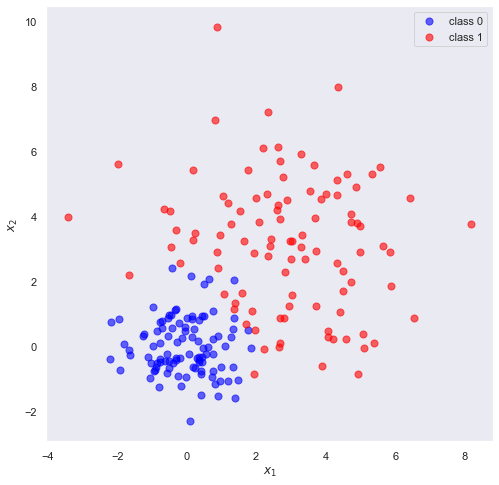

In [3]:
plt.figure(figsize=(8, 8))

plt.scatter(a[:, 0], a[:, 1], c='blue', s=50, alpha=0.6)
plt.scatter(b[:, 0], b[:, 1], c='red', s=50, alpha=0.6)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(['class 0', 'class 1'], loc='upper right')

Объединим матрицы в единую матрицу данных и создадим отдельный столбец меток класса:

In [4]:
X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

print (X.shape, y.shape)

(200, 2) (200,)


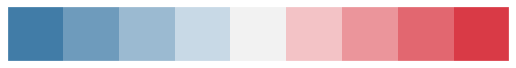

In [5]:
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.palplot(sns.diverging_palette(240, 10, n=9))

Можно визуализировать:

Text(0, 0.5, 'x2')

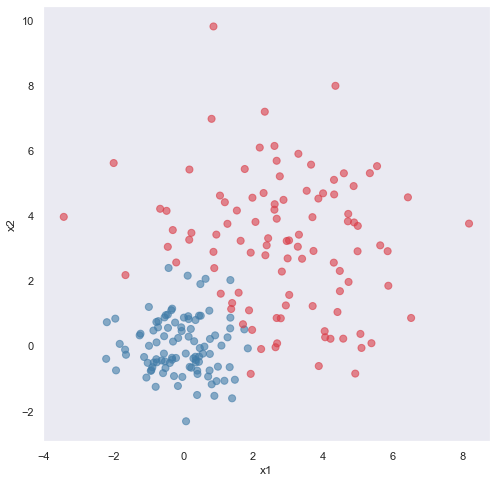

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.6, cmap=cmap)
plt.xlabel('x1')
plt.ylabel('x2')

## Обучение моделей

Попробуем обучить разные варианты [метода ближайших соседей](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) из scikit-learn.

Для начала обучим метод 3 ближайших соседей

In [7]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=1)
clf.fit(X, y)
print (clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


Предскажем метки для каких-нибудь точек

In [8]:
clf.predict([
             [2, 0],
             [10, 20],
             [-10, -20]
            ])

array([0., 1., 0.])

Предскажем вероятности каждой из меток

In [9]:
clf.predict_proba([
                   [2, 0],
                   [10, 20],
                   [-10, -20]
                   ])

array([[1., 0.],
       [0., 1.],
       [1., 0.]])

А что, если мы хотим помотреть как обученный алгоритм проводит разделяющую поверхность между объектами из признакового пространства?

Для начала напишем функцию для генерации карты точек:

In [10]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))

In [11]:
def plot_model(X, y, clf, proba=False):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.pcolormesh(xx, yy, predicted, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap=cmap, alpha=0.7, marker='H', edgecolors='black')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    return clf

Примерним классификатор к карте точек и визуализируем её

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

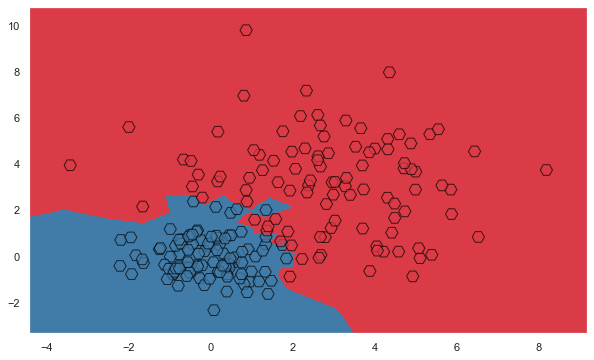

In [12]:
plt.figure(figsize=(10, 6))
plot_model(X, y, KNN(n_neighbors=1), proba=True)

Будем перебирать параметр число соседей и визуализировать полученное разбиение пространства объектов:

KNeighborsClassifier(algorithm='kd_tree', leaf_size=300, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

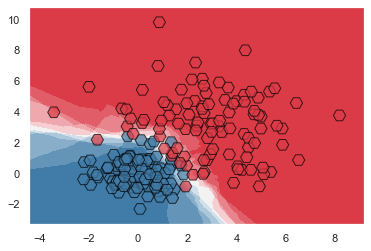

In [13]:
plot_model(X, y, KNN(n_neighbors=10, algorithm='kd_tree', leaf_size=300), proba=True)

## Как выбрать число соседей?

Разобьём данные на 2 части: обучение и контроль

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


Оценим качество работы для n_neighbors=3

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, KNN(n_neighbors=3).fit(X_train, y_train).predict(X_test))

0.9333333333333333

Оценим качество для каждого из значений n_neighbors из [1, n) и построим график зависимости качества от n_neighbors

In [17]:
n = 100
scores = []
for k in range(1, n):
    scores.append(accuracy_score(y_test, KNN(n_neighbors=k).fit(X_train, y_train).predict(X_test)))

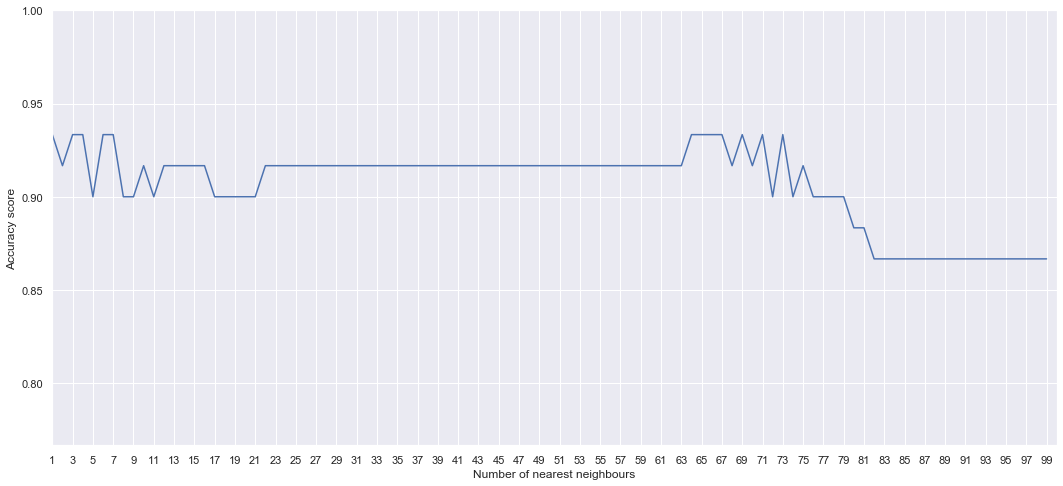

In [18]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), scores)
plt.xlim(1, n)
plt.ylim(np.min(scores) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

Из-за небольшого количества данных в тесте график получается шумным, и не до конца ясно, какое число соседей оптимально. Проведем кроссвалидацию средствами библиотеки sklearn

In [19]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, n)}
grid_searcher = GridSearchCV(clf, params, cv=5)
grid_searcher.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=1, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 100)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

Визуализируем полученные оценки качества и их $1\sigma$-доверительный интервал

In [20]:
df = pd.DataFrame(grid_searcher.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000803,0.000401,0.001597,0.000488,1,{'n_neighbors': 1},0.900,0.900,0.950,0.950,0.975,0.935,0.030000,26
1,0.000201,0.000401,0.002000,0.000001,2,{'n_neighbors': 2},0.925,0.925,0.950,0.950,0.950,0.940,0.012247,22
2,0.000606,0.000495,0.015399,0.027811,3,{'n_neighbors': 3},0.925,0.950,0.950,0.950,0.975,0.950,0.015811,5
3,0.000196,0.000392,0.001804,0.000394,4,{'n_neighbors': 4},0.925,0.925,0.975,0.975,0.975,0.955,0.024495,2
4,0.000396,0.000485,0.001604,0.000485,5,{'n_neighbors': 5},0.925,0.975,0.975,0.950,0.975,0.960,0.020000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000603,0.000493,0.001800,0.000401,95,{'n_neighbors': 95},0.825,0.875,0.925,0.925,0.875,0.885,0.037417,90
95,0.000400,0.000490,0.002001,0.000008,96,{'n_neighbors': 96},0.800,0.850,0.925,0.925,0.875,0.875,0.047434,97
96,0.000198,0.000397,0.001800,0.000399,97,{'n_neighbors': 97},0.825,0.850,0.925,0.925,0.875,0.880,0.040000,95
97,0.000200,0.000400,0.001799,0.000399,98,{'n_neighbors': 98},0.800,0.825,0.925,0.900,0.875,0.865,0.046368,98


In [21]:
means = df['mean_test_score']
stds = df['std_test_score']
n_neighbors = df['params'].apply(lambda x: x['n_neighbors'])

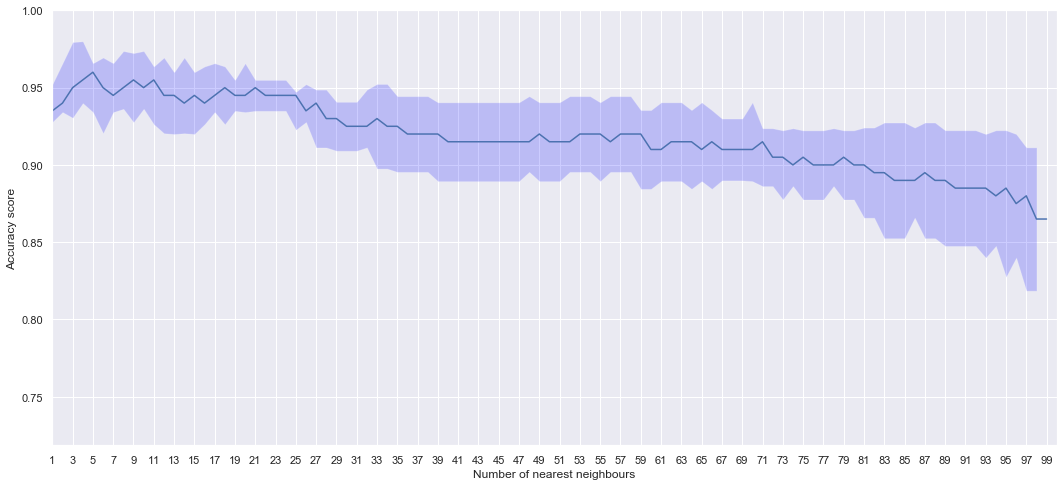

In [22]:
plt.figure(figsize=(18, 8))
plt.plot(n_neighbors, means)
plt.fill_between(range(len(means)), means + stds, means - stds, alpha = 0.2, facecolor='blue')
plt.xlim(1, n)
plt.ylim(np.min(means - stds) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

## Какие параметры ещё можно настраивать?

Помимо числа соседей, мы можем подбирать следующие параметры:

1. weights ('uniform', 'distance', [callable])
2. metric 
3. p (для метрики Минковского)

Кроме того, у KNeighborsClassifier есть параметр algorithm, который отвечает за алгоритм поиска ближайших соседей, который может позволить ускорить работу по сравнению с наивным подходом:

1. Brute force
2. [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)
3. [KDTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)
4. Auto

При использовании этих алгоритмов появляется и параметр для более детальной их настройки: leaf_size (для BallTree и KDTree)

## Масштабирование признаков

Загрузим набор данных [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data), где требуется предсказать сорт винограда, из которого изготовлено вино, используя результаты химических анализов. Более подробное описание данных можно посмотреть [здесь](https://archive.ics.uci.edu/ml/datasets/Wine).

In [23]:
data = pd.read_csv('wine.data', header=None)
print(data.shape)
data.head()

(178, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [24]:
data[0].value_counts()

2    71
1    59
3    48
Name: 0, dtype: int64

Сохраним отдельно матрицу объектов и столбец ответов

In [25]:
y = data[0].values
X = data.drop(0, axis=1).values
print(X.shape, y.shape)

(178, 13) (178,)


Подберём число соседей по кроссвалидации. Для этого напишем функцию, которая сделает это за нас

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cv_nn(n_neighbors, X, y):
    average_scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for k in n_neighbors:
        knn_clf = KNN(n_neighbors=k)
        scores = cross_val_score(knn_clf, X, y, cv=cv)
        average_scores.append(scores.mean())
    return average_scores

In [27]:
n_neighbors = range(1, 51)
average_scores = cv_nn(n_neighbors, X, y)

Посмотрим на то, что получилось:

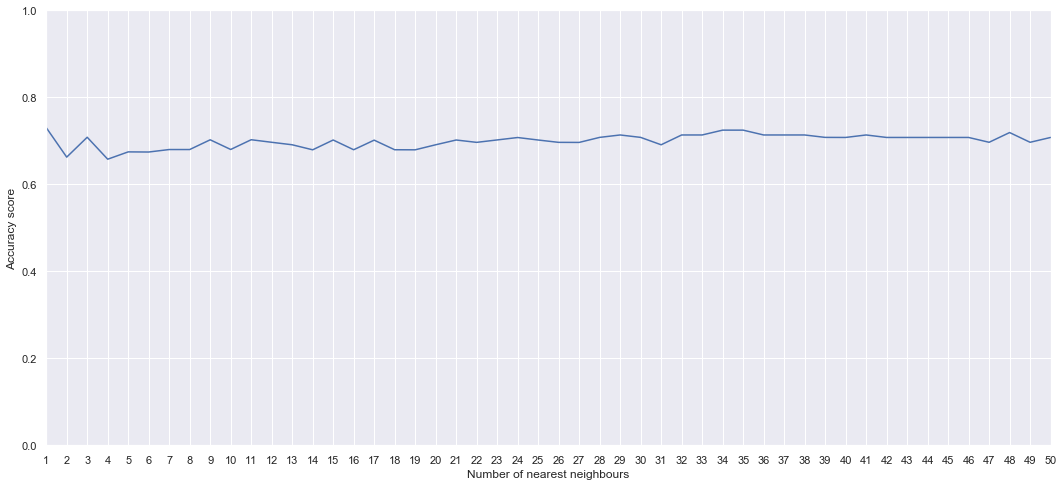

In [28]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.grid()

А теперь сперва отмасштабируем данные и проделаем то же самое

In [29]:
from sklearn.preprocessing import scale
X_scaled = scale(X)
average_scores_scaled = cv_nn(n_neighbors, X_scaled, y)

Сравним полученные результаты

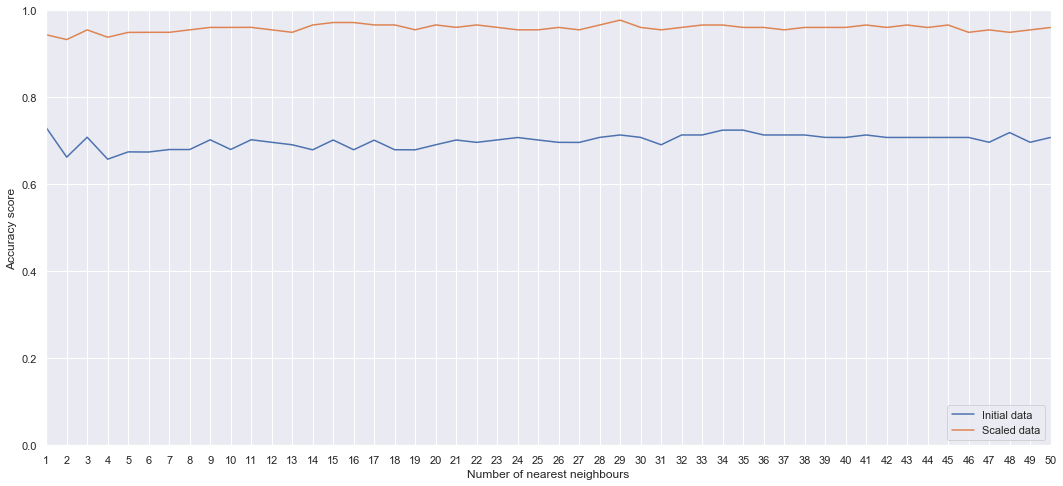

In [30]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
l2 = plt.plot(n_neighbors, average_scores_scaled)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.legend(['Initial data', 'Scaled data'], loc='lower right')
plt.grid()

Видно, что масштабирование данных сильно сказалось на качестве классификации.

## Проклятие размерности

![](https://2.downloader.disk.yandex.ru/preview/86e4c2752e9597d38721df7fcec530285080619a96d5304d4b18d968a593666a/inf/aeEgHcumGpaXdEIW73pGSkNH9oZwLkRa25vmf5WNu7beIcHlmoFmR7VTC8VdBFbIvJl-FABhBpMM1WVbnfLjJw%3D%3D?uid=165159067&filename=knn2.jpeg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&tknv=v2&size=1838x922)

**Задание 1 (1 балл)**. Для того, чтобы прочувствовать проклятие размерности, сделайте следующее. Сгенерируйте $\ell$ точек равномерно по объёму $n$-мерного куба с центром в нуле. Предположим, мы хотим протестировать метод ближайшего соседа для точки начала координат. Зададимся вопросом, на каком расстоянии будет ближайший сосед. Пусть $\ell=10000$. Постройте график зависимости медианы расстояния до ближайшего соседа (проведите генерацию несколько раз) от размерности $n$. 

In [31]:
def plot_distances(y_points, x_points, title='', xlabel='', ylabel='', xticks_step=5, xticks=None):
    plt.figure(figsize=(10, 7))
    
    plt.plot(x_points, y_points)
    if xticks:
        plt.xticks(x_points[::xticks_step], xticks[::xticks_step])
    else:
        plt.xticks(x_points[::xticks_step])
    plt.xlim(np.min(x_points), np.max(x_points))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    

In [32]:
l = 10000
max_dimension = 100

In [36]:
n_range = range(1, max_dimension + 1)
results_n = np.empty((5, max_dimension))

for j in n_range:
    for i in range(5):
        X = np.random.uniform(low=-0.5, high=0.5, size=(l, j))
        distances = np.sqrt(np.sum(X*X, axis=1))
        min_ind = np.argmin(distances)
        results_n[i, j - 1] = distances[min_ind]

In [37]:
medians_n = np.median(results_n, axis=0)

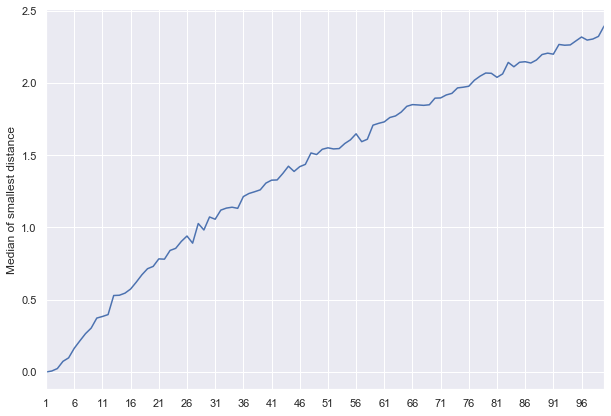

In [38]:
plot_distances(medians_n, n_range, 'Distances vs Dimensions', ylabel='Median of smallest distance')

Можем видеть, что с увеличением размерности пространства, увеличивается медиана расстояния до ближайщего соседа для точки начала координат.

**Задание 2 (0.5 балла)**. Пусть $n=100$. Постройте анлогичный график завимисти медианы от количества точек $\ell$.

In [39]:
l_range = range(1, l+1, 100)
results_l = np.empty((5, len(l_range)))

for ind, l_ in enumerate(l_range):
    for i in range(5):
        X = np.random.uniform(low=-0.5, high=0.5, size=(l_, max_dimension))
        
        distances = np.sqrt(np.sum(X*X, axis=1))
        min_ind = np.argmin(distances)
        results_l[i, ind] = distances[min_ind]

In [40]:
medians_l = np.median(results_l, axis=0)

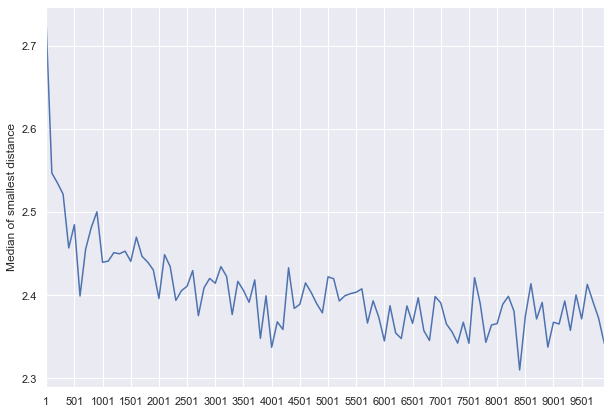

In [41]:
plot_distances(medians_l, range(len(medians_l)), 'Distances vs Object Amount', ylabel='Median of smallest distance', xticks=l_range)

По графику видно, что с увеличением количества объектов обучающей выборке, медиана расстояния до ближайщего соседа от начала координат уменьшается. Это объясняется тем, что увеличивается количество объектов, которые заполняют пространство и они становятся ближе друг к другу.

## Свой метод ближайших соседей

![](https://cdn-images-1.medium.com/max/800/1*otatqOkzhxFl4LXtkbDmhQ.jpeg)

**Задание 3  (1 балл)**. Реализуйте метод **одного** ближайшего соседа 1NN. Убедитесь, что он выдаёт на первой сегодняшней выборке такие же, как и встроенный алгоритм. Для этого нарисуйте разделяющую гиперплоскость, а также оцените качество для обоих алгоритмов.

**(+0.5 балла)** Реализуйте интерфейс классификатора sklearn и измерьте качество встроенными способами.

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin

class OneNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.X = None
        self.y = None
    
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
    
    @staticmethod
    def get_distance(x, X):
        return np.linalg.norm(X - x, axis=1)
    
    def predict(self, X):
        distances = np.apply_along_axis(OneNNClassifier.get_distance, 1, X, X=self.X)
        np.place(distances, distances == 0., np.inf)
        ind = np.argmin(distances, axis=1)
        return self.y[ind]


In [43]:
# data generation
np.random.seed(13)
n = 100
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))

X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

In [44]:
X_test = [
    [2, 0],
    [10, 20],
    [-10, -20]
]

### 1NN from box

In [45]:
clf_knn = KNN(n_neighbors=1)
clf_knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [46]:
clf_knn.predict(X_test)

array([0., 1., 0.])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

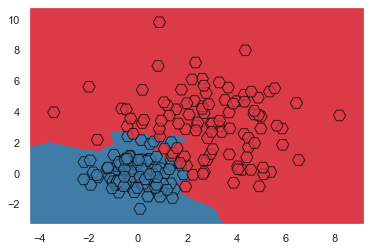

In [47]:
plot_model(X, y, KNN(n_neighbors=1))

### My 1NN

In [48]:
clf_onn = OneNNClassifier()
clf_onn.fit(X, y)

In [49]:
clf.predict(X_test)

array([0., 1., 0.])

OneNNClassifier()

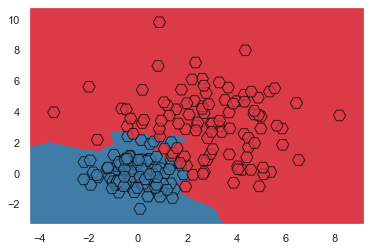

In [50]:
plot_model(X, y, OneNNClassifier())

### Validation

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

In [58]:
n_folds=5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

results_knn = []
results_onn = []

clf_knn = KNN(n_neighbors=1)
clf_onn = OneNNClassifier()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf_onn.fit(X_train, y_train)
    y_onn = clf_onn.predict(X_test)
    acc_onn = accuracy_score(y_test, y_onn)
    results_onn.append(acc_onn)
    
    clf_knn.fit(X_train, y_train)
    y_knn = clf_knn.predict(X_test)
    acc_knn = accuracy_score(y_test, y_knn)
    results_knn.append(acc_knn)

In [59]:
print(results_knn)
print(results_onn)

[0.95, 0.95, 0.875, 0.95, 0.975]
[0.95, 0.95, 0.875, 0.95, 0.975]


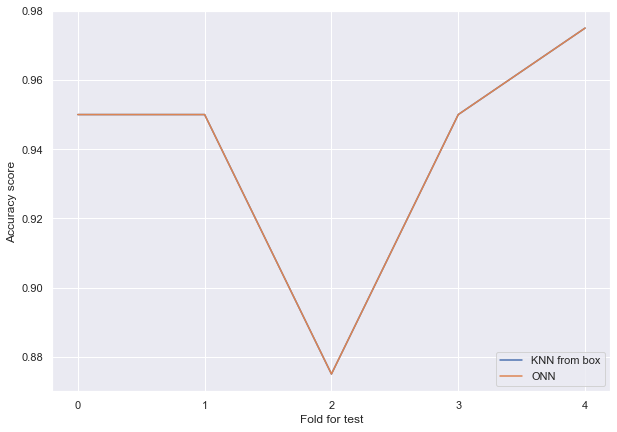

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(results_knn)
plt.plot(results_onn)
plt.xticks(range(n_folds))
plt.xlabel('Fold for test')
plt.ylabel('Accuracy score')
plt.legend(['KNN from box', 'ONN'], loc='lower right')
plt.grid()

In [61]:
print(cross_val_score(KNN(n_neighbors=1), X, y, cv=kf))
print(cross_val_score(OneNNClassifier(), X, y, cv=kf))

[0.95  0.95  0.875 0.95  0.975]
[0.95  0.95  0.875 0.95  0.975]


Можно видеть, что результаты для KNN из коробки и написанного ручками совпадают.